/usr/local/anaconda/envs/tensorflow2/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


datetime64[ns]
(1762, 6)
(1825, 6)
[Timestamp('2012-10-29 00:00:00'), Timestamp('2012-10-30 00:00:00')]
(1825, 6)
(1764, 6)
Before filling missing values:
 symbol    2
open      2
close     2
low       2
high      2
volume    2
dtype: int64

After filling missing values:
 symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64


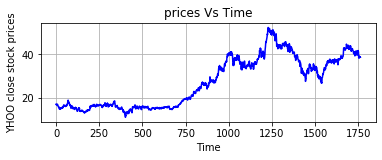

Train samples: 1411 Validation Samples: 176 Test Samples: 177
(1411, 1)
(176, 1)
(177, 1)
(1408, 2) (1408,) (173, 2) (173,) (174, 2) (174,)
(1408, 1, 2) (1408,) (173, 1, 2) (173,) (174, 1, 2) (174,)


/usr/local/anaconda/envs/tensorflow2/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 1, 100)            31200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 1, 150)            113400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
gru_8 (GRU)                  (None, 100)               75600     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('/cxldata/datasets/project/ny_stock_prediction/prices-split-adjusted.csv', header = 0)
df.head()
df.shape
df.symbol.unique()


df_yahoo = df[df['symbol']=='YHOO']
df_yahoo.head()
df_yahoo.shape


df_yahoo.describe
df_yahoo.isnull().sum()

df_yahoo['date']= pd.to_datetime(df_yahoo['date'])
print(df_yahoo.date.dtype)   
df_yahoo = df_yahoo.set_index("date")
df_yahoo.head()

print(df_yahoo.shape)
yahoo_data = df_yahoo.asfreq('b')
print(yahoo_data.shape)
yahoo_data.tail()
yahoo_data.isnull().sum()


null_data = yahoo_data[yahoo_data.isnull().any(axis = 1)]
null_data.head()
null_dates = null_data.index.tolist()




import calendar
import datetime

holidays = []

for date in null_dates:
    week, day, month, year = date.weekday(), date.day, date.month, date.year
    week_day = calendar.day_name[week]

    if month==1:
        if day==1:
            # New year day
            holidays.append(date)
        elif day==2 and week_day=='Monday':
            # Observed New Year Day
            holidays.append(date)
        elif day>=15 and day<=21 and week_day=='Monday':
            # Martin Luther King, Jr. Day
            holidays.append(date)

    elif month==2:
        # Washington's Birthday
        if day>=15 and day<=21 and week_day=='Monday':
            holidays.append(date)

    elif month==5:
        # Memorial day
        if day>=25 and day<=31 and week_day=='Monday':
            holidays.append(date)

    elif month==7:
        # Independence day
        if day==4:
            holidays.append(date)
        # Observed Independence  Day
        elif day==5 and week_day=='Monday':
            holidays.append(date)
        elif day==3 and week_day=='Friday':
            holidays.append(date)

    elif month == 9:
        # Labour day
        if day>=1 and day<=7 and week_day=='Monday':
            holidays.append(date)

    elif month==11:
        # Thanksgiving Day
        if week_day=='Thursday' and day>=22 and day<=28:
            holidays.append(date)

    elif month==12:
        # Christmas Day
        if day==25:
            holidays.append(date)
        # Observed Christmas Day
        elif day==24 and week_day=='Friday':
            holidays.append(date)
        elif day==26 and week_day=='Monday':
            holidays.append(date)

good_fridays = [ datetime.date(2010,4,2), datetime.date(2011,4,22), datetime.date(2012,4,6), datetime.date(2013,3,29), datetime.date(2014,4,18), datetime.date(2015,4,3), datetime.date(2016,3,25) ]
holidays = holidays + [pd.to_datetime(date) for date in good_fridays]

non_holidays = [x for x in null_dates if x not in holidays]
print(non_holidays)


print(yahoo_data.shape)
modified_df = yahoo_data.drop(holidays)
print(modified_df.shape)


print("Before filling missing values:\n", modified_df.isna().sum())
modified_df = modified_df.bfill(axis ='rows')
print("\nAfter filling missing values:\n",modified_df.isna().sum())


def plotter(code):
    global closing_stock
    plt.subplot(211)
    company_close = modified_df[modified_df['symbol']==code]
    company_close = company_close.close.values.astype('float32')
    company_close = company_close.reshape(-1, 1)
    closing_stock = company_close
    plt.xlabel('Time')
    plt.ylabel(code + " close stock prices")
    plt.title('prices Vs Time')
    plt.grid(True)
    plt.plot(company_close , 'b')
    plt.show()

plotter("YHOO")


n_train = int(len(closing_stock) * 0.80)
n_remaining = len(closing_stock) - n_train

n_val = int(n_remaining*0.50)
n_test = n_remaining - n_val 
print("Train samples:",n_train, "Validation Samples:",n_val,"Test Samples:", n_test)
train_data = closing_stock[0:n_train]
print(train_data.shape)
val_data = closing_stock[n_train:n_train+n_val]
print(val_data.shape)
test_data = closing_stock[n_train+n_val: ]
print(test_data.shape)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train_data)
val = scaler.transform(val_data)
test = scaler.transform(test_data)

def create_dataset(data , n_features):
    dataX, dataY = [], []
    for i in range(len(data)-n_features-1):
        a = data[i:(i+n_features), 0]
        dataX.append(a)
        dataY.append(data[i + n_features, 0])
    return np.array(dataX), np.array(dataY)

n_features = 2
trainX, trainY = create_dataset(train, n_features)
valX, valY = create_dataset(val, n_features)
testX, testY = create_dataset(test, n_features)
print(trainX.shape , trainY.shape , valX.shape , valY.shape, testX.shape , testY.shape)
trainX = trainX.reshape(trainX.shape[0] , 1 ,trainX.shape[1])
valX = valX.reshape(valX.shape[0] , 1 ,valX.shape[1])
testX = testX.reshape(testX.shape[0] , 1 ,testX.shape[1])
print(trainX.shape , trainY.shape , valX.shape , valY.shape, testX.shape , testY.shape)



import tensorflow as tf
tf.random.set_seed(42)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam


model = keras.Sequential()
model.add(layers.GRU(units=100, return_sequences=True, input_shape=(1,n_features), activation='tanh'))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(units=150, return_sequences=True, input_shape=(1,n_features), activation='tanh'))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(units=100, activation='tanh'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1, kernel_initializer='he_uniform', activation='linear'))


model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics = ['mean_squared_error'])

print(model.summary())
history = model.fit(trainX,trainY,epochs=100,batch_size=128, verbose=1, validation_data = (valX,valY))

import math

def model_score(model, X_train, y_train, X_val, y_val , X_test, y_test):
    print('Train Score:')
    train_score = model.evaluate(X_train, y_train, verbose=0)
    print("MSE: {:.5f} , RMSE: {:.2f}".format(train_score[0], math.sqrt(train_score[0])))

    print('Validation Score:')
    val_score = model.evaluate(X_val, y_val, verbose=0)
    print("MSE: {:.5f} , RMSE: {:.2f}".format (val_score[0], math.sqrt(val_score[0])))

    print('Test Score:')
    test_score = model.evaluate(X_test, y_test, verbose=0)
    print("MSE: {:.5f} , RMSE: {:.2f}".format (test_score[0], math.sqrt(test_score[0])))


model_score(model, trainX, trainY ,valX, valY , testX, testY)

In [13]:
import math

def model_score(model, X_train, y_train, X_val, y_val , X_test, y_test):
    print('Train Score:')
    train_score = model.evaluate(X_train, y_train, verbose=0)
    print("MSE: {:.5f} , RMSE: {:.2f}".format(train_score[0], math.sqrt(train_score[0])))

    print('Validation Score:')
    val_score = model.evaluate(X_val, y_val, verbose=0)
    print("MSE: {:.5f} , RMSE: {:.2f}".format (val_score[0], math.sqrt(val_score[0])))

    print('Test Score:')
    test_score = model.evaluate(X_test, y_test, verbose=0)
    print("MSE: {:.5f} , RMSE: {:.2f}".format (test_score[0], math.sqrt(test_score[0])))


model_score(model, trainX, trainY ,valX, valY , testX, testY)

Train Score:
MSE: 0.00018 , RMSE: 0.01
Validation Score:
MSE: 0.00037 , RMSE: 0.02
Test Score:
MSE: 0.00023 , RMSE: 0.02


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


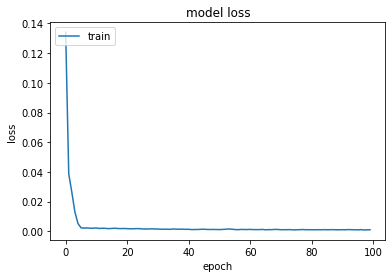

In [14]:
print(history.history.keys())
plt.plot(history.history['loss'])  # plotting train loss


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

[[37.652534]
 [37.42834 ]
 [37.271576]
 [37.128403]
 [36.84003 ]
 [36.735134]
 [36.691746]
 [36.32445 ]
 [36.156303]
 [36.77799 ]]
[[37.23]
 [37.11]
 [36.95]
 [36.59]
 [36.6 ]
 [36.53]
 [36.01]
 [36.  ]
 [36.94]
 [37.23]]


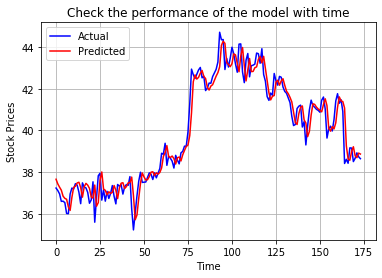

In [15]:
pred = model.predict(testX)
pred = scaler.inverse_transform(pred)
print(pred[:10])

testY_actual = testY.reshape(testY.shape[0] , 1)
testY_actual = scaler.inverse_transform(testY_actual)
print(testY_actual[:10])

plt.plot(testY_actual , 'b')
plt.plot(pred , 'r')

plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('Check the performance of the model with time')
plt.legend(['Actual', 'Predicted'], loc='upper left')

plt.grid(True)
plt.show()